In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import random
import pandas_profiling
from pycaret.regression import setup, compare_models, create_model, tune_model

In [64]:
train_df = pd.read_csv('train.csv')
train_df['type'] = 'train'
test_df = pd.read_csv('test.csv')
test_df['type'] = 'test'

In [65]:
train_df.drop(['Customer Id', 'Artist Name'], axis = 1, inplace = True)
test_df.drop('Artist Name', axis = 1, inplace = True)

In [66]:
train_df.drop_duplicates(inplace = True)

In [67]:
categorical_vars = train_df.select_dtypes(include = [np.object])
continuous_vars = train_df.select_dtypes(include = [np.number])
continuous_vars

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,Cost
0,0.26,17.0,6.0,4128.0,13.91,16.27,-283.29
1,0.28,3.0,3.0,61.0,6.83,15.00,-159.96
2,0.07,8.0,5.0,237.0,4.96,21.18,-154.29
3,0.12,9.0,NaN,NaN,5.81,16.31,-161.16
4,0.15,17.0,6.0,324.0,3.18,11.94,-159.23
...,...,...,...,...,...,...,...
6495,0.37,37.0,10.0,16551.0,28.28,38.46,872.43
6496,0.67,15.0,NaN,18981.0,67.18,27.72,1347.02
6497,0.68,19.0,8.0,587.0,6.92,10.38,354.55
6498,0.02,33.0,9.0,1269377.0,2929.13,69.76,5037.50


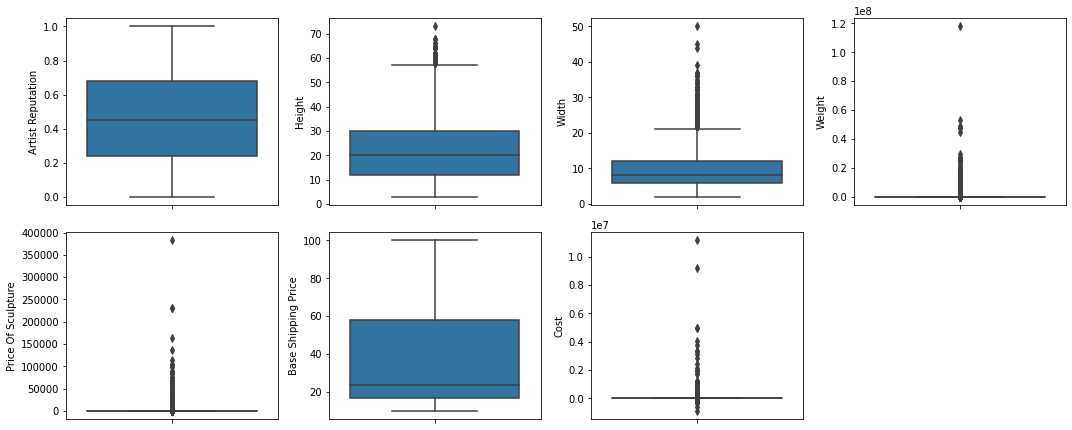

In [27]:
fig = plt.figure(figsize = (15, 9))
for i in range(len(continuous_vars.columns)):
    fig.add_subplot(3, 4, i+1)
    sns.boxplot(y = continuous_vars.iloc[:, i])
plt.tight_layout()
plt.show()

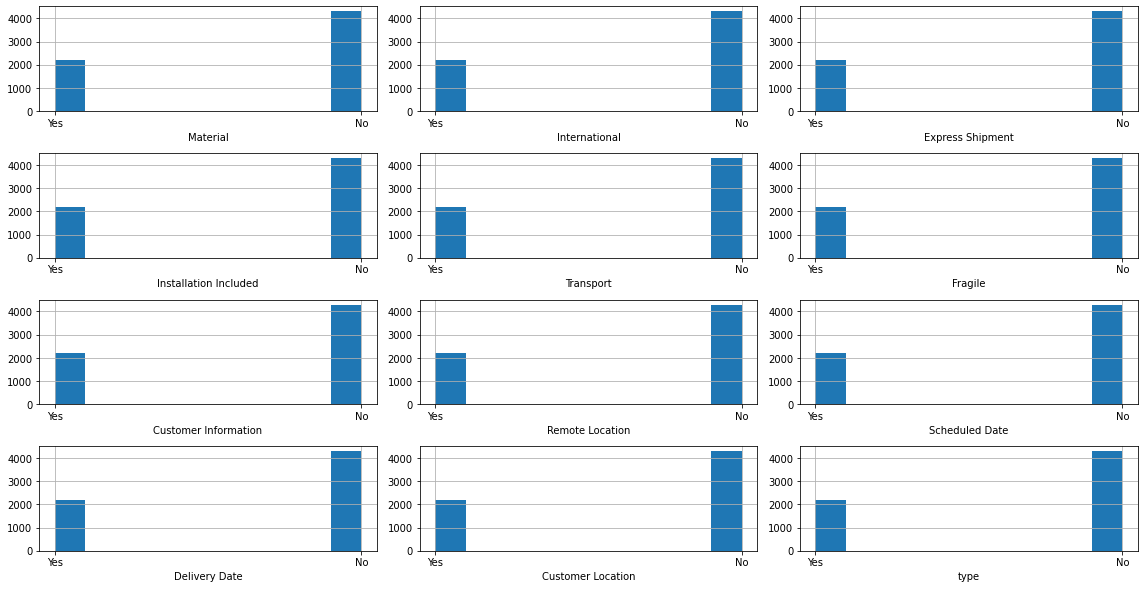

In [33]:
fig = plt.figure(figsize = (16, 16))
for i in range(len(categorical_vars.columns)):
    fig.add_subplot(8, 3, i+1)
    categorical_vars.iloc[:, 1].hist()
    plt.xlabel(categorical_vars.columns[i])
plt.tight_layout()
plt.show()

In [28]:
categorical_vars

,Material,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,type
0,Brass,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",train
1,Brass,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",train
2,Clay,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",train
3,Aluminium,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",train
4,Aluminium,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",train
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,Brass,Yes,Yes,No,Airways,No,Wealthy,Yes,03/28/18,03/25/18,"New Robert, VT 85335",train
6496,NaN,No,No,No,Roadways,No,Working Class,No,08/29/15,08/27/15,"New Joshua, VA 35766",train
6497,Clay,Yes,No,No,NaN,Yes,Wealthy,No,04/10/19,04/09/19,"Lake Kelly, MA 80823",train
6498,Stone,No,Yes,No,Roadways,No,Working Class,Yes,03/10/19,03/12/19,"Hintonberg, UT 35006",train


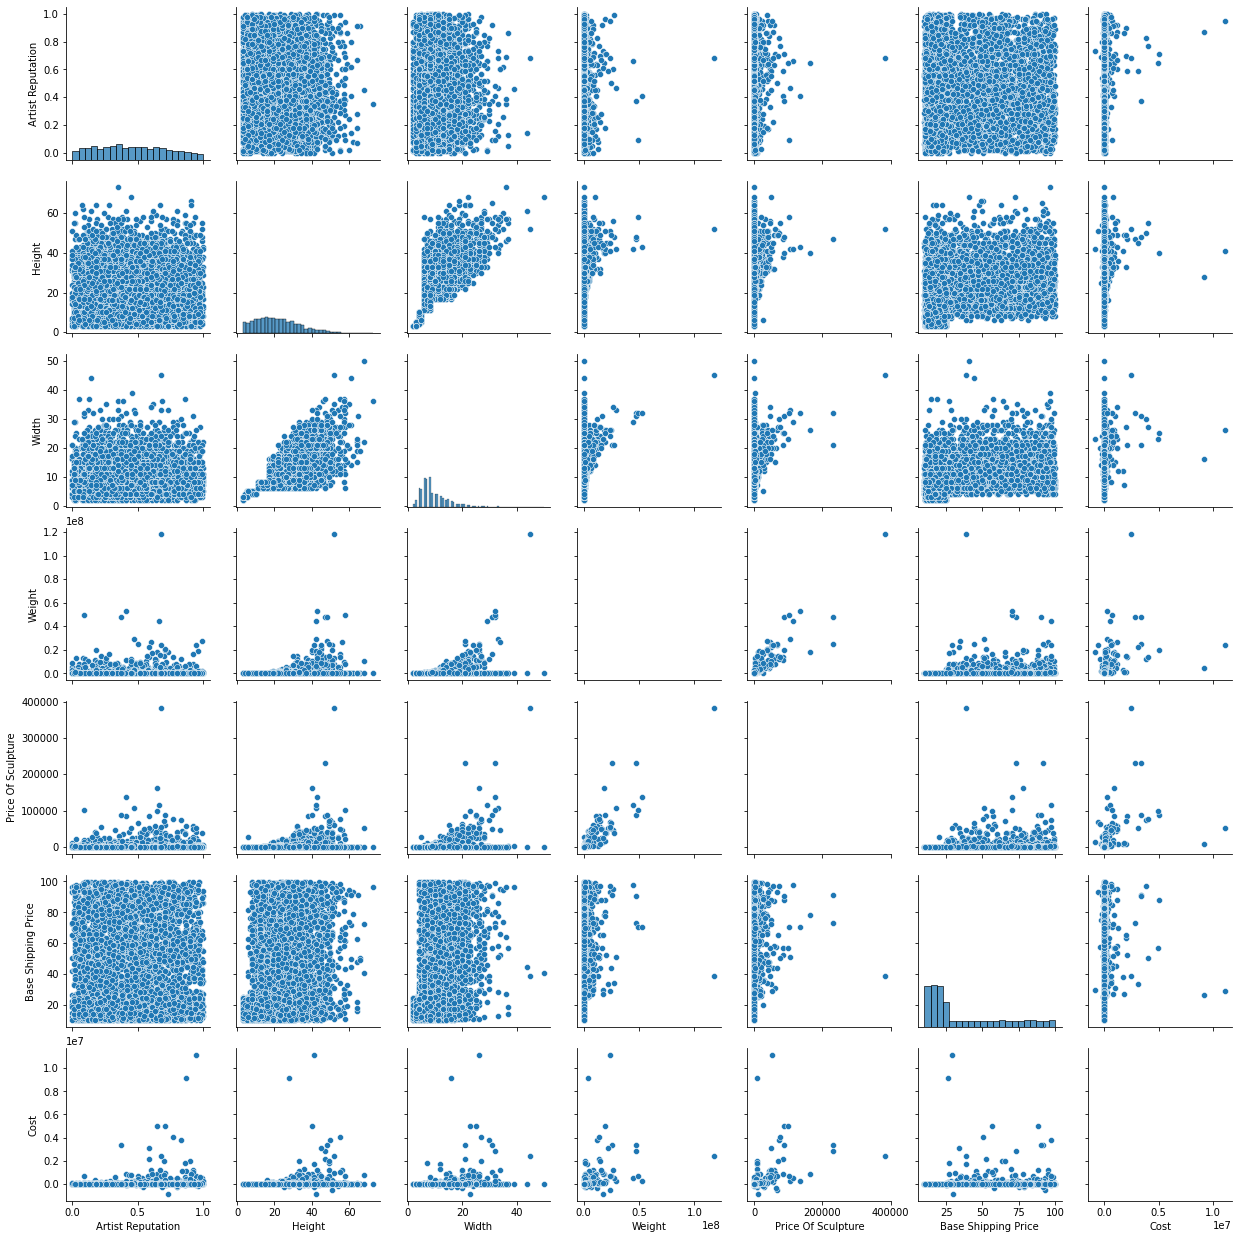

In [35]:
sns.pairplot(train_df)

<AxesSubplot:>

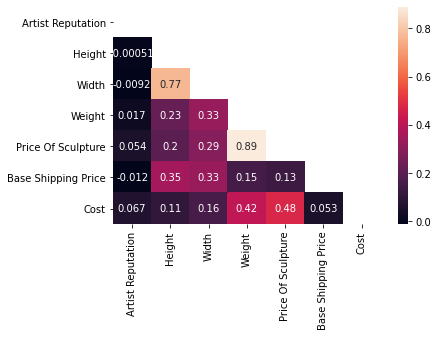

In [68]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype = np.bool))
sns.heatmap(corr, mask = mask, annot = True)

<AxesSubplot:>

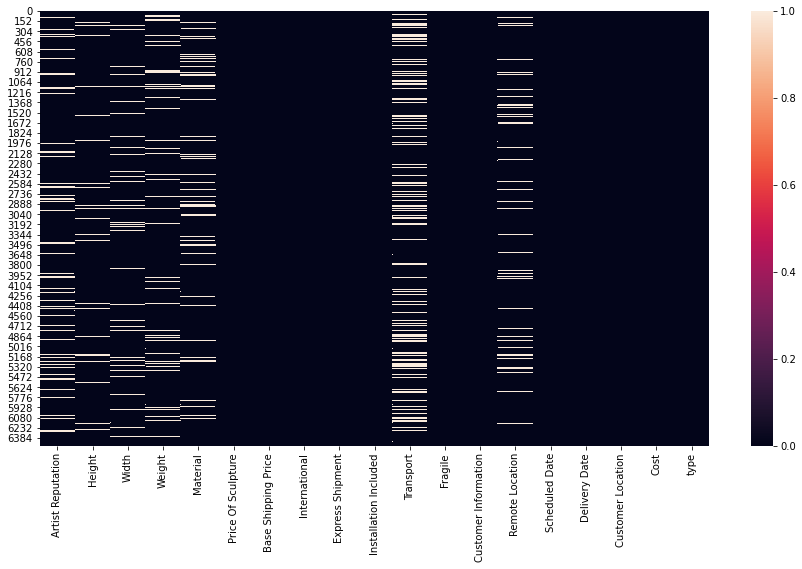

In [69]:
plt.figure(figsize = (15, 8))
sns.heatmap(train_df.isnull())

In [70]:
train_df['Height'].fillna(train_df['Height'].median(), inplace = True)
train_df['Width'].fillna(train_df['Width'].median(), inplace = True)
train_df['Weight'].fillna(train_df['Weight'].median(), inplace = True)
train_df['Artist Reputation'].fillna(train_df['Artist Reputation'].median(), inplace = True)

In [78]:
train_df['Material'].fillna(train_df['Material'].mode()[0], inplace = True)
train_df['Transport'].fillna(train_df['Transport'].mode()[0], inplace = True)
train_df['Remote Location'].fillna(train_df['Remote Location'].mode()[0], inplace = True)

### Replaced Catgorical Vars by integers based upon their mean costs

In [54]:
train_df.groupby('Material')['Cost'].mean()

Material
Aluminium      297.635929
Brass         1172.391795
Bronze        1215.958258
Clay           496.584939
Marble       35581.790354
Stone        79381.991826
Wood           240.637733
Name: Cost, dtype: float64

In [79]:
train_df['Material'].replace({'Wood':1, 'Aluminium':2, 'Clay':3, 'Brass':4, 'Bronze':5, 'Marble':6, 'Stone':7}, inplace = True)

In [59]:
train_df.groupby('Transport')['Cost'].mean()

Transport
Airways      23955.360633
Roadways     15134.364559
Waterways     7739.928549
Name: Cost, dtype: float64

In [73]:
train_df['Transport'].replace({'Waterways':1, 'Roadways':2, 'Airways':3}, inplace = True)

### Replace Binary vars with 0 and 1

In [76]:
train_df.replace({'Yes':1, 'No':0}, inplace = True)

<AxesSubplot:>

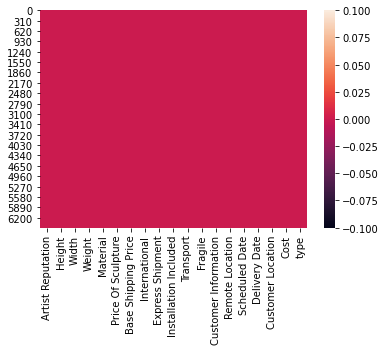

In [80]:
sns.heatmap(train_df.isnull())

In [81]:
train_df.dtypes

Artist Reputation        float64
Height                   float64
Width                    float64
Weight                   float64
Material                 float64
Price Of Sculpture       float64
Base Shipping Price      float64
International              int64
Express Shipment           int64
Installation Included      int64
Transport                  int64
Fragile                    int64
Customer Information      object
Remote Location            int64
Scheduled Date            object
Delivery Date             object
Customer Location         object
Cost                     float64
type                      object
dtype: object

In [82]:
train_df.groupby('Customer Information')['Cost'].mean()

Customer Information
Wealthy          18560.296871
Working Class    16637.090995
Name: Cost, dtype: float64

In [84]:
train_df['Customer Information'].replace({'Working Class':0, 'Wealthy':1}, inplace = True)

In [85]:
train_df['Scheduled Date'] = pd.to_datetime(train_df['Scheduled Date'])
train_df['Delivery Date'] = pd.to_datetime(train_df['Delivery Date'])
train_df['days'] = (train_df['Scheduled Date'] - train_df['Delivery Date']).map(lambda x: str(x).split()[0])
train_df['days'] = pd.to_numeric(train_df['days'])

In [88]:
train_df.drop(['Scheduled Date', 'Delivery Date'], axis = 1, inplace = True)

In [87]:
state = train_df['Customer Location'].apply(lambda x: x.split()[-2])
train_df['Customer Location'] = state

In [89]:
train_df.dtypes

Artist Reputation        float64
Height                   float64
Width                    float64
Weight                   float64
Material                 float64
Price Of Sculpture       float64
Base Shipping Price      float64
International              int64
Express Shipment           int64
Installation Included      int64
Transport                  int64
Fragile                    int64
Customer Information       int64
Remote Location            int64
Customer Location         object
Cost                     float64
type                      object
days                       int64
dtype: object

In [90]:
train_df.drop('type', axis = 1, inplace = True)

In [97]:
from sklearn.preprocessing import LabelEncoder

In [99]:
lbl = LabelEncoder()
lbl_enc = lbl.fit_transform(train_df['Customer Location'])
train_df['Customer Location'] = lbl_enc

In [100]:
train_df.dtypes

Artist Reputation        float64
Height                   float64
Width                    float64
Weight                   float64
Material                 float64
Price Of Sculpture       float64
Base Shipping Price      float64
International              int64
Express Shipment           int64
Installation Included      int64
Transport                  int64
Fragile                    int64
Customer Information       int64
Remote Location            int64
Customer Location          int32
Cost                     float64
days                       int64
dtype: object

In [134]:
df_copy = train_df.copy()

In [135]:
df_shuffle = df_copy.sample(frac = 1).reset_index(drop = True)
df_shuffle.shape

(6500, 17)

In [136]:
df_y = df_shuffle.pop('Cost')
df_X = df_shuffle

In [137]:
print(df_y)
df_y = abs(df_y)
print(df_y)

0       2907.00
1        226.78
2        377.58
3        150.52
4        483.07
         ...   
6495     624.45
6496     429.57
6497     313.62
6498    2160.68
6499     657.27
Name: Cost, Length: 6500, dtype: float64
0       2907.00
1        226.78
2        377.58
3        150.52
4        483.07
         ...   
6495     624.45
6496     429.57
6497     313.62
6498    2160.68
6499     657.27
Name: Cost, Length: 6500, dtype: float64


#### apply log on target feature with abs as it has many negative values

In [138]:
df_y = np.log1p(abs(df_y))
df_y

0       7.975221
1       5.428380
2       5.936427
3       5.020718
4       6.182230
          ...   
6495    6.438471
6496    6.065110
6497    5.751366
6498    7.678641
6499    6.489615
Name: Cost, Length: 6500, dtype: float64

In [139]:
min(df_y)

4.466712392840524

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=105)

In [141]:
import sklearn.linear_model as sklm

In [144]:
ridge_model = sklm.RidgeCV(scoring = 'neg_mean_squared_error',
                           alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10],
                          cv = 5)
ridge_model.fit(X_train, y_train)

y_train_preds = ridge_model.predict(X_train)
y_test_preds = ridge_model.predict(X_test)

train_error = mean_absolute_error(y_train, y_train_preds)
test_error = mean_absolute_error(y_test, y_test_preds)
train_error, test_error

(0.5780503295087828, 0.5416222284669169)

In [151]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [10, 100, 200, 300, 500, 1000],
          'max_depth': np.arange(2, 18, 2)}
rfr_model = GridSearchCV(estimator = RandomForestRegressor(criterion = 'mse'),
                        param_grid = params, scoring = 'neg_mean_squared_error',
                        cv = 6)
rfr_model.fit(X_train, y_train)
rfr_model.best_params_, rfr_model.best_score_

({'max_depth': 16, 'n_estimators': 300}, -0.12333462660090211)

In [149]:
from sklearn.ensemble import GradientBoostingRegressor

In [150]:
gb_model = GradientBoostingRegressor(max_depth = 10, criterion = 'mse', n_estimators = 100)
gb_model.fit(X_train, y_train)
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
train_error = mean_absolute_error(y_train, y_train_preds)
test_error = mean_absolute_error(y_test, y_test_preds)
train_error, test_error

(0.0074915446292917074, 0.20516149977961498)

# Since the Competition was over, we were not able to test the accuracy on Test Set